In [1]:

# Reads the Hagrid static gesture dataset saved as a compressed npz file
import numpy as np
import pandas as pd

def load_hagrid_saved_npz(npz_path: str) -> pd.DataFrame:
    npz = np.load(npz_path, allow_pickle=True)
    arr = np.array(npz[npz.files[0]])  # use first array (e.g. 'arr_0' if unnamed)
    if arr.ndim != 2 or arr.shape[1] != 64:
        raise ValueError(f"Expected shape (N,64), got {arr.shape}")
    labels = arr[:, 0]
    X = arr[:, 1:].astype(float)  # 63 feature columns

    cols = []
    for i in range(21):
        cols += [f"x{i}", f"y{i}", f"z{i}"]

    df = pd.DataFrame(X, columns=cols)
    df.insert(0, "label", labels)
    return df

# Usage
Hagrid = load_hagrid_saved_npz("output/compressed/hagrid_static_gestures.npz")
Hagrid.head() # shows the first few rows
Hagrid.groupby("label").size() # shows counts per label

label
call              26480
dislike           25602
fist              25327
four              27754
like              25692
mute              25672
ok                26756
one               26879
palm              27580
peace             25525
peace_inverted    24353
rock              25978
stop               2647
dtype: int64

In [ ]:
def add_empty_rows(df: pd.DataFrame, n: int = 5, label_value=None, feature_fill=np.nan) -> pd.DataFrame:
    """
    Return a new DataFrame with `n` appended rows:
    - first column is treated as the label and set to `label_value` (e.g. None)
    - remaining columns are filled with `feature_fill` (default NaN)
    """
    if n <= 0:
        return df.copy()

    df_copy = df.copy()
    cols = df_copy.columns.tolist()
    label_col = cols[0]
    feature_cols = cols[1:]

    # Ensure label column can hold None
    df_copy[label_col] = df_copy[label_col].astype(object)

    data = {label_col: [label_value] * n}
    for c in feature_cols:
        data[c] = [feature_fill] * n

    empty_df = pd.DataFrame(data, columns=cols)
    return pd.concat([df_copy, empty_df], ignore_index=True)


In [2]:
#Hagrid = add_empty_rows(Hagrid, n =20000, label_value="None")
# shuffle the DataFrame rows
shuffled_df = Hagrid.sample(frac=1).reset_index(drop=True)
print(shuffled_df.groupby("label").size())
shuffled_df.head()

label
call              26480
dislike           25602
fist              25327
four              27754
like              25692
mute              25672
ok                26756
one               26879
palm              27580
peace             25525
peace_inverted    24353
rock              25978
stop               2647
dtype: int64


,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20
0,rock,0.537460,0.681029,5.535284e-09,0.444696,0.666634,-0.052285,0.369293,0.563824,-0.074474,...,-0.067184,0.598109,0.310577,-0.130639,0.601554,0.236169,-0.144397,0.603231,0.166377,-0.140214
1,dislike,0.561934,0.352764,-2.850769e-07,0.541059,0.383862,-0.010127,0.515288,0.410916,-0.017425,...,-0.013164,0.496887,0.329945,-0.015413,0.510203,0.337727,-0.009355,0.513613,0.335201,-0.004759
2,ok,0.281068,0.814483,9.420477e-07,0.379552,0.821004,-0.038041,0.479865,0.774341,-0.060326,...,-0.070877,0.259974,0.440389,-0.107184,0.277040,0.367413,-0.126236,0.303466,0.305828,-0.134619
3,ok,0.476936,0.889329,6.568661e-07,0.552635,0.842947,-0.035308,0.611519,0.768016,-0.057067,...,-0.065642,0.306478,0.633376,-0.096059,0.266429,0.591205,-0.104977,0.235433,0.548626,-0.105213
4,call,0.803717,0.650380,-4.727325e-07,0.819643,0.539857,-0.016687,0.807185,0.444139,-0.035412,...,-0.048337,0.467812,0.642420,-0.053461,0.413893,0.631875,-0.049329,0.368149,0.616885,-0.047001


In [3]:
# Check registered labels
registered_labels = shuffled_df["label"].unique()
print(F"Registered labels: {registered_labels}")


Registered labels: ['rock' 'dislike' 'ok' 'call' 'peace' 'like' 'palm' 'mute' 'one' 'four'
 'fist' 'peace_inverted' 'stop']


In [4]:
"""
Prepare data for training:
-Remove rows with label "None"
-Normalize features to [0,1]
-Encode labels
-Split into train and test sets
"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf

# Filter out rows where label is "None"
mask = shuffled_df['label'] != "None"
filtered_df = shuffled_df[mask]

labels = filtered_df['label']
features = filtered_df.iloc[:, 1:].astype(float)
print("Features shape after removing 'None':", features.shape)

# Normalize features to [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(features.values)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print(encoder.classes_)


Features shape after removing 'None': (316245, 63)
Train shape: (252996, 63) (252996,)
Test shape: (63249, 63) (63249,)
['call' 'dislike' 'fist' 'four' 'like' 'mute' 'ok' 'one' 'palm' 'peace'
 'peace_inverted' 'rock' 'stop']


In [5]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(63,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(len(encoder.classes_), activation="softmax")
])
# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)


Epoch 1/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8369 - loss: 0.4808 - val_accuracy: 0.9488 - val_loss: 0.2073
Epoch 2/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9478 - loss: 0.1813 - val_accuracy: 0.9680 - val_loss: 0.1340
Epoch 3/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9620 - loss: 0.1350 - val_accuracy: 0.9726 - val_loss: 0.1099
Epoch 4/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9709 - loss: 0.1086 - val_accuracy: 0.9750 - val_loss: 0.0973
Epoch 5/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9752 - loss: 0.0947 - val_accuracy: 0.9767 - val_loss: 0.0882
Epoch 6/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9770 - loss: 0.0879 - val_accuracy: 0.9728 - val_loss: 0.0924
Epoch 7/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9790 - loss: 0.0805 - val_accuracy: 0.9815 - val_loss: 0.0725
Epoch 8/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9796 - loss: 0

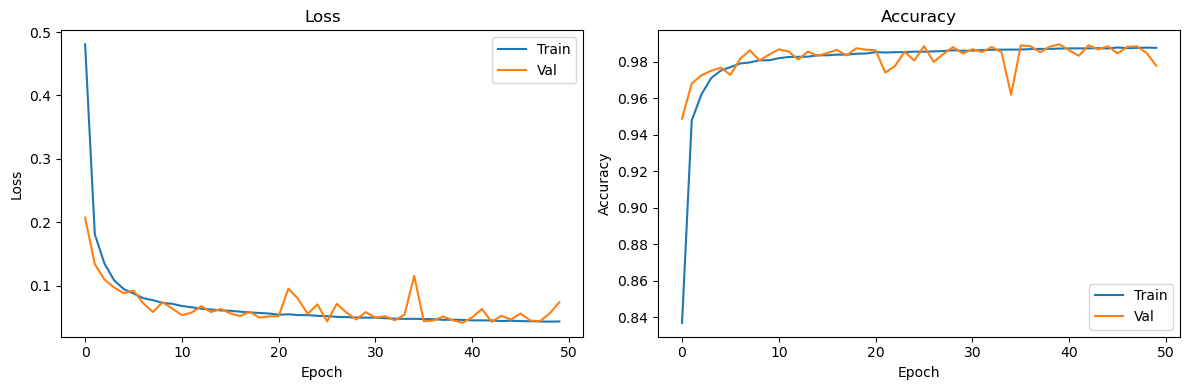

In [6]:
# Plot training history to see how loss and accuracy evolved
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(["Train", "Val"])

# Accuracy
axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(["Train", "Val"])

plt.tight_layout()
plt.show()


In [7]:
# Check which labels are present in X_test
unique_labels_test = [encoder.classes_[i] for i in np.unique(y_test)]
print("Labels in X_test:", unique_labels_test)


Labels in X_test: ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop']


In [8]:
import numpy as np

def get_random_sample_from_test(X_test, y_test, encoder):
    """
    Randomly select a label from X_test that exists, then return a random sample
    and its true label.
    """
    # Get unique label IDs in the test set
    available_label_ids = np.unique(y_test)

    # Pick one label ID at random
    label_id = np.random.choice(available_label_ids)

    # Pick a random sample with that label
    indices = np.where(y_test == label_id)[0]
    idx = np.random.choice(indices)

    # Return features and true label
    X_sample = X_test[idx]
    y_sample = y_test[idx]

    # Convert label ID back to label name
    label_name = encoder.classes_[label_id]

    return X_sample, y_sample, label_name

# Get a random sample from test set
X_sample, y_sample, actual_label = get_random_sample_from_test(X_test, y_test, encoder)

# Prepare for prediction
sample = X_sample.reshape(1, -1)
pred = model.predict(sample)

predicted_label = encoder.classes_[np.argmax(pred)]

print("Predicted:", predicted_label)
print("Actual   :", actual_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted: stop
Actual   : stop


In [9]:
import numpy as np

def evaluate_random_samples(X_test, y_test, encoder, model, n=100):
    # Evaluate model accuracy over n random samples from X_test
    correct = 0

    for _ in range(n):
        # Get a random sample
        available_label_ids = np.unique(y_test)
        label_id = np.random.choice(available_label_ids)
        indices = np.where(y_test == label_id)[0]
        idx = np.random.choice(indices)

        X_sample = X_test[idx].reshape(1, -1)
        y_sample = y_test[idx]

        # Predict
        pred = model.predict(X_sample, verbose=0)
        predicted_label = encoder.classes_[np.argmax(pred)]
        actual_label = encoder.classes_[y_sample]

        if predicted_label == actual_label:
            correct += 1

    accuracy = correct / n
    print(f"Random-sample accuracy over {n} samples: {accuracy:.2%}")

# Run evaluation
evaluate_random_samples(X_test, y_test, encoder, model, n=100)


Random-sample accuracy over 100 samples: 96.00%


In [11]:
"""
Export the trained model and label mapping
:returns a folder model/hagrid_vN where N is the next version number
- model saved in Keras (.keras) or SavedModel format
- labels saved in labels.json
"""
import json
import os
import glob
import subprocess


# Base model directory
BASE_MODEL_DIR = "model/hagrid"

# Ensure base directory exists
os.makedirs("model", exist_ok=True)

# Find existing versions
existing_versions = glob.glob(f"{BASE_MODEL_DIR}_v*")
version_numbers = [
    int(v.split("_v")[-1]) for v in existing_versions if v.split("_v")[-1].isdigit()
]
next_version = max(version_numbers, default=0) + 1

# Create version folder
VERSION_DIR = f"{BASE_MODEL_DIR}_v{next_version}"
os.makedirs(VERSION_DIR, exist_ok=True)

# Choose export format
EXPORT_FORMAT = "keras"  # options: "keras" or "savedmodel"

if EXPORT_FORMAT == "keras":
    MODEL_FILE = os.path.join(VERSION_DIR, "model")
    # model.save(MODEL_FILE)
    tf.saved_model.save(model, MODEL_FILE)  # Ensure compatibility
    print(f"Saved Keras model to {MODEL_FILE}")
else:  # SavedModel format
    MODEL_DIR = os.path.join(VERSION_DIR, "saved_model")
    model.export(MODEL_DIR)
    print(f"Saved SavedModel to {MODEL_DIR}")

# Save label mapping inside the same folder
LABELS_FILE = os.path.join(VERSION_DIR, "labels.json")
label_mapping = {int(i): label for i, label in enumerate(encoder.classes_)}
with open(LABELS_FILE, "w") as f:
    json.dump(label_mapping, f, indent=4)

print(f"Saved labels to {LABELS_FILE}")
print(f"All files for version {next_version} are in {VERSION_DIR}")




INFO:tensorflow:Assets written to: model/hagrid_v2\model\assets


INFO:tensorflow:Assets written to: model/hagrid_v2\model\assets


Saved Keras model to model/hagrid_v2\model
Saved labels to model/hagrid_v2\labels.json
All files for version 2 are in model/hagrid_v2


In [ ]:
"""Convert the saved Keras model to TensorFlow Lite format"""
import tensorflow as tf
import os

# Version directory
VERSION_DIR = "model/hagrid_v1"
keras_model_file = os.path.join(VERSION_DIR, "model.keras")
tflite_model_file = os.path.join(VERSION_DIR, "model.tflite")

# Load Keras model
model = tf.keras.models.load_model(keras_model_file)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved to {tflite_model_file}")
